# 개요

* 최종과제
  * 기존에 진행했던 과제에서 해보지 않았던 것 위주로 진행해보고자 함함
    * GPU(CUDA)설정 : docker 및 전용 torch 패키지 설치 등
    * autogluon으로 빠르게 베이스모델 설정 후(medium quality설정) 결정력 없는 변수 먼저 제거
    * SHAP시각화 진행시, EDA로 전처리하기 전보다 데이터의 경향성 등을 확인하기 어려웠음
  * 학습했던 음수변수에 대한 최소값 조정 등 진행
  * One-hot, Ordinal 인코딩에 대해 배웠는데, 상하관계 혼동을 주지않으면서 컬럼 수를 증가시키지 않는 방법 고민
    * Leaveoneout 인코딩이라는 것을 적용. 향후에는 좀 더 알아보고 적용하면 좋을 것 같음
  * 전처리한 데이터를 바탕으로 autogluon(best quality)으로 고도화된 모델을 얻고자 함
    * 데이터에 대한 반영과 AutoML을 반복하며 개선을 진행하고자하였으나, 시간관계상 1회만 진행함
    * 1회만 진행하며 오히려 점수는 조금 떨어짐.
    * 향후 파생변수 생성 등 데이터에 좀 더 중점을 둔 방법으로 진행해보면 좋을 것 같음

# 최종과제

## 과제 목표 및 데이터 설명

* 과제 목표
  * 차량소유 여부 등 데이터를 바탕으로, 고객의 신용도를 예측(대금연체를 기준으로 한 신용도)
  * **`Logloss`의 최소화**
* 데이터 설명
  * 데이터 출처 : [월간 데이콘 신용카드 사용자 연체 예측 AI 경진대회 데이터](https://dacon.io/competitions/official/235713/overview/description)
    * 세부 출처 : https://mp.weixin.qq.com/s/upjzuPg5AMIDsGxlpqnoCg
  * 변수 설명 [(데이콘설명 원본링크)](https://www.dacon.io/competitions/official/235713/talkboard/402821/?_gl=1%2a1qi5pgu%2a_gcl_au%2aMTY1MzAzMjUwMi4xNzMyNDU0MDQ2%2a_ga%2aNTU2Mjg0MDUwLjE3MjQxMzkwODk.%2a_ga_35PZM515YN%2aMTczNjI1MzI0NS4xOC4xLjE3MzYyNTMyNjQuNDEuMC4w)
    * gender: 성별
    * car: 차량 소유 여부
    * reality: 부동산 소유 여부
    * child_num: 자녀 수
    * income_total: 연간 소득
    * income_type: 소득 분류 ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
    * edu_type: 교육 수준 ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
    * family_type: 결혼 여부 ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']
    * house_type: 생활 방식 ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']
    * DAYS_BIRTH: 출생일
      * 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
    * DAYS_EMPLOYED: 업무 시작일
      * 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미
      * 양수 값은 고용되지 않은 상태를 의미함
    * FLAG_MOBIL: 핸드폰 소유 여부
    * work_phone: 업무용 전화 소유 여부
    * phone: 전화 소유 여부
    * email: 이메일 소유 여부
    * occyp_type: 직업 유형													
    * family_size: 가족 규모
    * begin_month: 신용카드 발급 월
      * 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미
    * **credit**: 사용자의 신용카드 대금 연체를 기준으로 한 신용도
      * 낮을 수록 높은 신용의 신용카드 사용자를 의미함

## 

## EDA : 기초통계 등

* 데이터 로딩 및 train x,y로 분할

In [ ]:
from pkb_sqlite3 import DB_sqlite3
import pandas as pd

# db로 저장해둔 데이터 읽기
db_controller = DB_sqlite3('Dacon_creditcard_overdue.db')

df_train = db_controller.search_db_show_df('SELECT * FROM train')
df_test = db_controller.search_db_show_df('SELECT * FROM test')
df_sample_submission = db_controller.search_db_show_df('SELECT * FROM sample_submission')

# 데이터 나누기
Y_train = df_train['credit'].copy()
X_train = df_train.drop('credit',axis=1).copy()
X_test = df_test.copy()

# 나눠진 데이터 확인
print(f"""* 전체 : {df_train.shape}
* x_train : {X_train.shape}
* y_train : {Y_train.shape}""")

* 전체 : (26457, 20)
* x_train : (26457, 19)
* y_train : (26457,)


* describe()를 활용한 데이터 확인
  * index컬럼은 삭제
  * **unique**와 **top**을 기준으로, `gender`, `income_type` 등 컬럼은 범주형 변수로 추측
  * **count**를 기준으로, `occyp_type`컬럼은 결측치가 많을 것으로 추측
  * **count**대비 **freq**값을 참고하여, `house_type` 등 컬럼이 편향되어 있음을 추측

In [ ]:
X_train.describe(include='all').transpose().reset_index()

,index,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,index,26457.0,NaN,NaN,NaN,13228.0,7637.622372,0.0,6614.0,13228.0,19842.0,26456.0
1,gender,26457,2,F,17697,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,car,26457,2,N,16410,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,reality,26457,2,Y,17830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,child_num,26457.0,NaN,NaN,NaN,0.428658,0.747326,0.0,0.0,0.0,1.0,19.0
5,income_total,26457.0,NaN,NaN,NaN,187306.524493,101878.367995,27000.0,121500.0,157500.0,225000.0,1575000.0
6,income_type,26457,5,Working,13645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,edu_type,26457,5,Secondary / secondary special,17995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,family_type,26457,5,Married,18196,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,house_type,26457,6,House / apartment,23653,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 결측치 처리 : 직업유형(occyp_type)의 결측치는 무직을 의미할까?

* **결측치가 69%에 해당하여 삭제가 아닌 대체**로 진행 필요함
* 결측치에 **맥락이나 의미**가 있는지에 대한 고민
  * 직업유형에 '무직'을 뜻하는 단어가 없음 → None은 무직을 의미하는가?
    ```
    array([None, 'Laborers', 'Managers', 'Sales staff',
        'High skill tech staff', 'Core staff', 'Drivers', 'Medicine staff',
        'Accountants', 'Realty agents', 'Security staff', 'Cleaning staff',
        'Private service staff', 'Cooking staff', 'Secretaries',
        'HR staff', 'IT staff', 'Low-skill Laborers',
        'Waiters/barmen staff'], dtype=object)
    ```
  * 실제로 직업이 없음을 의미하는 데이터로 검증
    * 방법 : DAYS_EMPLOYED(고용일)이 양수인 경우 무직. 이를 대조함
      * 직업유형이 None인 값 중, 고용기간이 있는 값과 없는 값이 공존
      ```python
      # DAYS_EMPLOYED 고용기간 있음
      len(X_train[(X_train['occyp_type'].isna())&(X_train['DAYS_EMPLOYED']<0)])
      >>> 3733
      # DAYS_EMPLOYED 고용기간 없음
      len(X_train[(X_train['occyp_type'].isna())&(X_train['DAYS_EMPLOYED']<0)])
      >>> 4438
      ```
      * **고용기간도 없는 경우는 'NoJob'으로 대체**

In [ ]:
# 결측치 처리 함수
def fill_occyp_type(row):
    if pd.isna(row['occyp_type']):
        if row['DAYS_EMPLOYED'] > 0:
            return 'NoJob'
    return row['occyp_type']

X_train['occyp_type'] = X_train.apply(fill_occyp_type, axis=1)
X_train['occyp_type'].unique()

array([None, 'Laborers', 'Managers', 'Sales staff',
       'High skill tech staff', 'Core staff', 'Drivers', 'Medicine staff',
       'Accountants', 'NoJob', 'Realty agents', 'Security staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Secretaries', 'HR staff', 'IT staff', 'Low-skill Laborers',
       'Waiters/barmen staff'], dtype=object)

## train/validate/test 데이터셋으로 정리

In [ ]:
from sklearn.model_selection import train_test_split

# index컬럼 삭제
X_train = X_train.drop(columns=['index'])
X_test = X_test.drop(columns=['index'])

# 데이터 분할
x_train, x_validate, y_train, y_validate= train_test_split(X_train, Y_train, test_size=0.3, random_state=42, stratify=Y_train)

## 빠른 처리를 위한 GPU설정

* CUDA 설치 : https://developer.nvidia.com/cuda-downloads?target_os=Windows&target_arch=x86_64&target_version=11&target_type=exe_local
* CUDA버전 확인 : 12.1
* CUDA버전에 맞는, GPU지원되는 torch버전으로 설치

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Wed_Jan_15_19:38:46_Pacific_Standard_Time_2025
Cuda compilation tools, release 12.8, V12.8.61
Build cuda_12.8.r12.8/compiler.35404655_0


In [ ]:
# 설치된 torch버전을 확인해, torch.version.cuda가 None인 경우 CUDA지원버전으로 torch 재설치
import torch

# torch가 GPU지원버전인지 확인(+cu121)
print(torch.__version__)
print(torch.version.cuda)  # CUDA 버전 확인 (None이면 GPU 미지원 버전)
print(torch.cuda.is_available())  # False면 GPU 미지원

# 사용가능한 GPU확인
print(torch.cuda.device_count())  # 사용 가능한 GPU 개수
print(torch.cuda.get_device_name(0))  # 첫 번째 GPU 이름

2.5.1+cu121
12.1
True
1
NVIDIA GeForce RTX 2060 SUPER


## 평가 Metric 설정

* 대회 규정에 맞춰 `Logloss`를 primary metric으로 설정
* 데이터를 좀 더 용이하게 파악하고, 소통 등의 이점을 위해 보조 지표 설정
  * balance accuracy, weighted f1-score, roc_auc

## Autogluon 활용한 베이스 모델

In [ ]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import f1_score
import numpy as np

# 저장할 경로 지정
path = 'autogluon_1basemodel' # 저장할 경로

# Autogluon이 지원하지 않는 metric함수 설정(logloss로 평가예정으로 여기서는 미사용)
def weighted_f1_autogluon(y_true, y_pred_proba):
    y_pred = np.argmax(y_pred_proba, axis=1)
    return f1_score(y_true, y_pred, average='weighted')

# AutoGluon을 위해 데이터프레임으로 병합
train_data = x_train
train_data['target'] = y_train

val_data = x_validate
val_data['target'] = y_validate

# AutoGluon 학습
predictor = TabularPredictor(
    label='target', 
    problem_type='multiclass', 
    eval_metric='log_loss', 
    verbosity=2,
    path=path
)
predictor.fit(
    train_data,
    tuning_data=val_data,
    time_limit=3600,  # 시간 제한 설정 (1시간)
    num_gpus=1
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
Memory Avail:       5.73 GB / 15.94 GB (35.9%)
Disk Space Avail:   504.61 GB / 931.51 GB (54.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good accura

[1000]	valid_set's multi_logloss: 0.760515


	-0.7594	 = Validation score   (-log_loss)
	25.16s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 3544.53s of the 3544.52s of remaining time.
	Training LightGBM with GPU, note that this may negatively impact model quality compared to CPU training.
	-0.7514	 = Validation score   (-log_loss)
	11.64s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: RandomForestGini ... Training model for up to 3532.74s of the 3532.74s of remaining time.
	-0.7675	 = Validation score   (-log_loss)
	1.74s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: RandomForestEntr ... Training model for up to 3530.57s of the 3530.56s of remaining time.
	-0.7735	 = Validation score   (-log_loss)
	1.94s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 3528.25s of the 3528.24s of remaining time.
	Training CatBoost with GPU, note that this may negatively impact model quality compar

In [ ]:
# 단순 참고용
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

# 예측 및 평가
test_data = x_validate
test_data['target'] = y_validate

y_pred_proba_ag = predictor.predict_proba(test_data)
y_pred_ag = predictor.predict(test_data)

y_pred = predictor.predict(test_data)
y_proba = predictor.predict_proba(test_data)
accuracy = accuracy_score(test_data['target'], y_pred)
logloss = log_loss(test_data['target'], y_proba)
cf = confusion_matrix(test_data['target'], y_pred)

In [ ]:
predictor.leaderboard(x_validate, extra_metrics=['balanced_accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'])

,model,score_test,balanced_accuracy,f1_weighted,roc_auc_ovr_weighted,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.719272,0.506493,0.679734,0.759321,-0.719287,log_loss,1.010035,0.467401,122.088188,0.006076,0.001995,0.671924,2,True,14
1,LightGBMLarge,-0.741424,0.473018,0.658814,0.734866,-0.741424,log_loss,0.145274,0.116242,39.248754,0.145274,0.116242,39.248754,1,True,13
2,LightGBM,-0.751353,0.453062,0.644461,0.723493,-0.751353,log_loss,0.158483,0.090607,11.635407,0.158483,0.090607,11.635407,1,True,5
3,XGBoost,-0.757927,0.465824,0.651667,0.720750,-0.757927,log_loss,0.178037,0.036000,5.536725,0.178037,0.036000,5.536725,1,True,11
4,LightGBMXT,-0.759434,0.459947,0.645968,0.718343,-0.759434,log_loss,0.324177,0.224359,25.162158,0.324177,0.224359,25.162158,1,True,4
5,CatBoost,-0.761541,0.439993,0.633287,0.713087,-0.761541,log_loss,0.074158,0.026571,26.207678,0.074158,0.026571,26.207678,1,True,8
6,RandomForestGini,-0.767504,0.534628,0.685285,0.752369,-0.767504,log_loss,0.331259,0.102593,1.737886,0.331259,0.102593,1.737886,1,True,6
7,RandomForestEntr,-0.773531,0.532764,0.684485,0.752317,-0.773531,log_loss,0.299343,0.100369,1.936155,0.299343,0.100369,1.936155,1,True,7
8,ExtraTreesEntr,-0.781154,0.514000,0.672208,0.737642,-0.781154,log_loss,0.451465,0.101042,1.143195,0.451465,0.101042,1.143195,1,True,10
9,ExtraTreesGini,-0.784103,0.515487,0.674453,0.736337,-0.784103,log_loss,0.368600,0.121832,1.149729,0.368600,0.121832,1.149729,1,True,9


## XAI(SHAP)를 통한 데이터 확인 및 불필요한 변수 제거

* WeightedEnsemble_L2모델은 KernelExplainer 실행시 76~79시간 소요 예상
* 데이터의 확인과 변수를 걸러낼 용도이므로, 빠르게 가능하면서 2번째로 성능이 좋았던 모델로 SHAP 확인
  * X_train을 넣엇으나, 데이터구성이 다르다는 오류 발생 (autogluon이 제거했던 feature가 있었음)
    * 확인해보니 휴대폰 소유여부로, 요즘 시대에 중요한 변수는 아닐 것 같은 생각이 들어 제외하기로 함
    ```
    set(X_train) - set(model.feature_name())
    >>> {'FLAG_MOBIL'}
    ```

In [ ]:
import numpy as np
import shap

# FLAG_MOBIL 드랍
X_train = X_train.drop(columns='FLAG_MOBIL')

# Autogluon의 모델 가져오기
model = predictor._trainer.load_model("LightGBMLarge").model

# SHAP계산을 위해 Autogluon의 피쳐형태와 동일하게 만들기
X_train_transformed = predictor.transform_features(X_train)

# Explainer를 활용한 SHAP 계산
explainer = shap.TreeExplainer(model)
shap_values_train = explainer.shap_values(X_train_transformed)

# 전체 SHAP값의 절대값의 평균으로 Feature Importance 구하기
shap_values_mean = np.mean(np.abs(shap_values_train), axis=(0, 2))  # (35,) 크기

print(f"""SHAP value의 Shape              : {shap_values_train.shape}
SHAP Feature Importance의 Shape : {shap_values_mean.shape}""")

SHAP value의 Shape              : (26457, 17, 3)
SHAP Feature Importance의 Shape : (17,)


* Feature importance 확인
  * 소득이나 교육수준 등 일반적으로 영향을 미칠것으로 보이는 feature들이 상위에 보임
  * importance가 0인 경우는 없어, 현재 상황에서 feature삭제는 별도로 하지 않음
    * 지난 실습때는 전체fit & SHAP importance산출 후 0이었던 FLAG_MOBIL을 직접 삭제
    * 이번에는 autogluon을 통해 영향없는 feature로 자동 제외됨

In [ ]:
import pandas as pd

feature_importance = pd.DataFrame({
    'Feature': [f'{X_train.columns[i]}' for i in range(shap_values_mean.shape[0])],
    'Importance': shap_values_mean
}).sort_values(by='Importance', ascending=False)

feature_importance

,Feature,Importance
11,work_phone,0.309656
5,income_type,0.126218
6,edu_type,0.093286
4,income_total,0.087204
16,begin_month,0.083925
12,phone,0.029627
13,email,0.021359
14,occyp_type,0.020650
3,child_num,0.019754
10,DAYS_EMPLOYED,0.018939


* 신용도 높음(0)과 낮음(2)에 대해서 SHAP Summary plot 시각화
  * 회색은 영향도가 낮은 값이라고 하며, 해당하는 값인 소득수준 등이 제외할 정도로 무의미한 값으로는 판단되지 않아 삭제는 하지 않음
  * 전반적으로 섞여있거나 유의미하게 특징적인 부분은 발견하지 못함

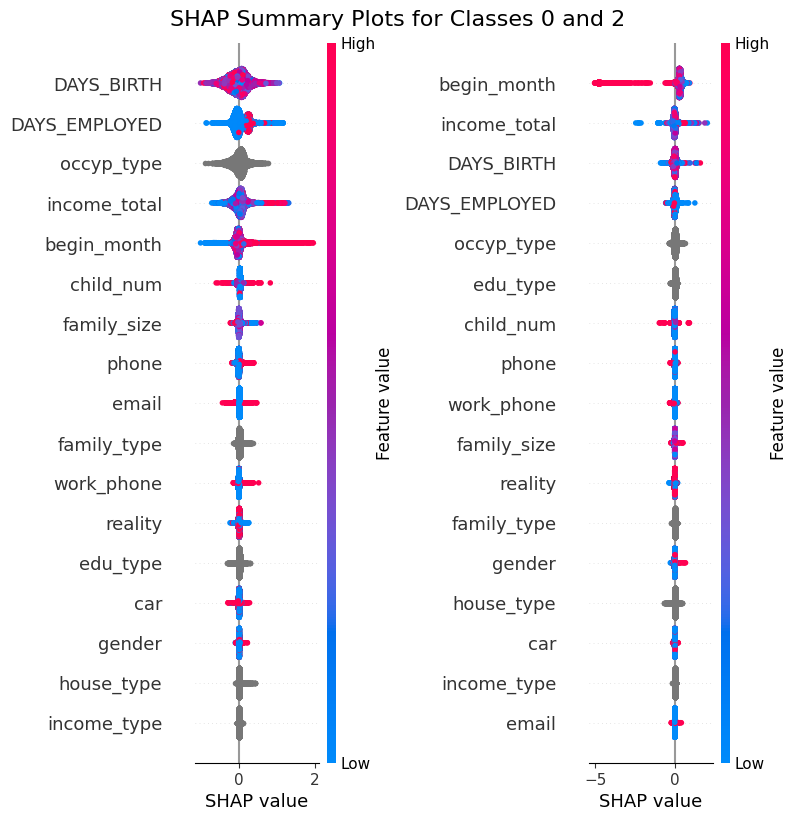

In [ ]:
import matplotlib.pyplot as plt
import shap

# 글꼴 크기 조정
plt.rcParams.update({'font.size': 8})

# 그림 생성 및 크기 설정 (2개의 서브플롯)
fig, axes = plt.subplots(1, 2, figsize=(30, 8))

# Class 0에 대한 SHAP 값 시각화
plt.sca(axes[0])
shap.summary_plot(
    shap_values_train[:, :, 0],
    X_train_transformed,
    feature_names=X_train_transformed.columns,
    plot_type="dot",
    show=False,
    title="Class 0"
)
axes[0].set_xlabel("SHAP value")

# Class 2에 대한 SHAP 값 시각화
plt.sca(axes[1])
shap.summary_plot(
    shap_values_train[:, :, 2],
    X_train_transformed,
    feature_names=X_train_transformed.columns,
    plot_type="dot",
    show=False,
    title="Class 2"
)
axes[1].set_xlabel("SHAP value")

# 전체 그림 제목 설정
plt.suptitle("SHAP Summary Plots for Classes 0 and 2", fontsize=16)

# 그림 간격 조정
plt.tight_layout()

# 그림 표시
plt.show()


## 데이터 전처리를 위한 추가 EDA

### 수치형 변수의 EDA 및 전처리 방향

* 유무(0,1)만을 나타내는 값은 별도로 처리하지 않음 : `work_phone`, `phone`, `email`
* 음수변수는 최소값 조정 : `DAYS_BIRTH`, `DAYS_EMPLOYED`, `begin_month`
* 왜도/첨도/이상치 확인에 따라 추가적인 조정 : `DAYS_BIRTH`, `DAYS_EMPLOYED`, `begin_month`, `child_num`, `income_total`, `family_size`
  * 왜도가 크고, IQR기준 이상치를 보유한 3개 변수에 대해 로그변환 진행 : `child_num`, `income_total`, `DAYS_EMPLOYED`
  * 타 변수 대비 값의 규모(천~만 단위)가 달라 발생할 수 있는 문제를 방지하고자 정규화(Min-Max) : `DAYS_BIRTH`

In [ ]:
# 수치형 변수 추출
x_numerical = X_train.select_dtypes(include=['float64', 'int64'])

* 전반적인 시각화 및 왜도/첨도 확인
  * 왜도가 큰 3개 변수 : `child_num`, `income_total`, `DAYS_EMPLOYED`

In [ ]:
# 왜도/첨도 분석
df_to_analyze = x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'child_num', 'income_total', 'family_size']]

numeric_skew = df_to_analyze.skew().reset_index().rename(columns={0: '왜도', 'index':'feature_s'}).sort_values(by='왜도')
numeric_kurt = df_to_analyze.kurtosis().reset_index().rename(columns={0: '첨도', 'index':'feature_k'}).sort_values(by='첨도')

pd.concat([numeric_skew.reset_index(), numeric_kurt.reset_index()], axis=1)[['feature_s','왜도','feature_k','첨도']]

,feature_s,왜도,feature_k,첨도
0,begin_month,-0.290050,DAYS_BIRTH,-1.046188
1,DAYS_BIRTH,-0.185986,begin_month,-1.041906
2,family_size,1.431759,DAYS_EMPLOYED,1.161734
3,DAYS_EMPLOYED,1.777596,family_size,10.578051
4,income_total,2.659271,income_total,16.359621
5,child_num,2.852376,child_num,29.172394


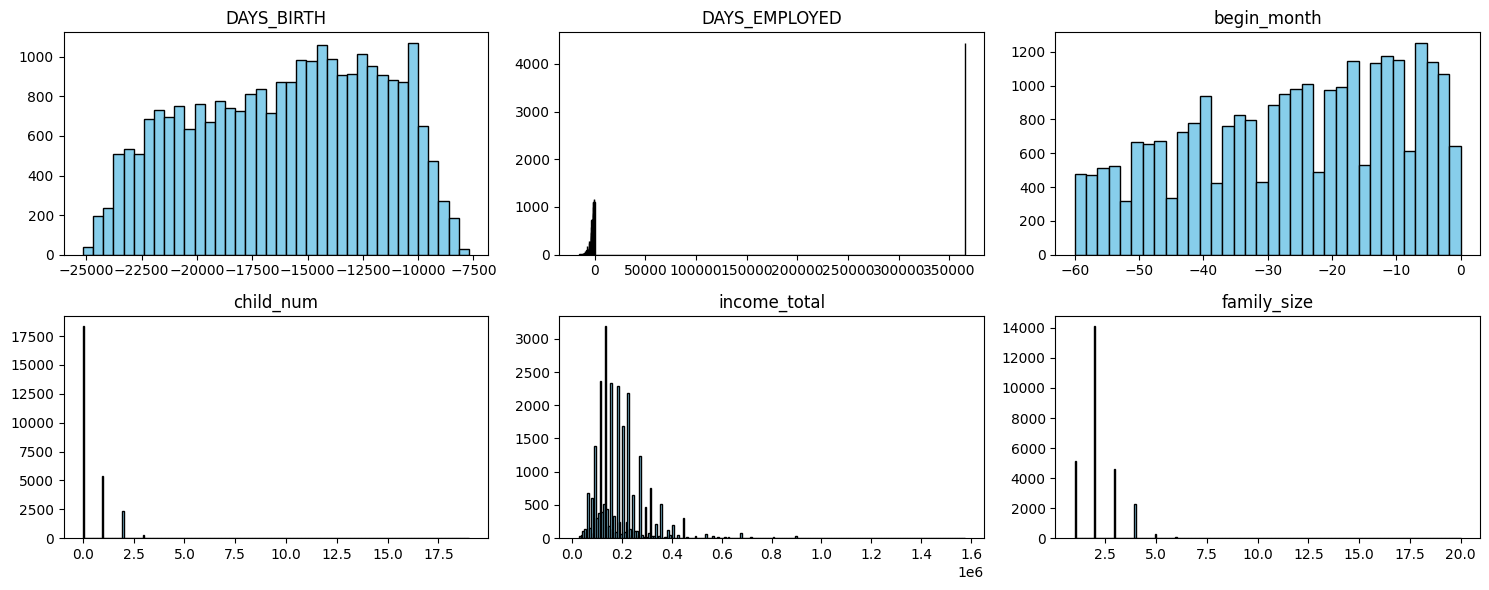

In [ ]:
# 히스토그램 시각화를 통한 확인
import matplotlib.pyplot as plt
import math

# 시각화 대상
columns_to_visualize = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'child_num', 'income_total', 'family_size']
df_to_visualize = x_numerical[columns_to_visualize]

# 설정: 가로 그래프 개수
cols = 3
num_vars = len(columns_to_visualize)
rows = math.ceil(num_vars / cols)  # 필요한 행(row) 수 계산

# 서브플롯 생성
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))  # 전체 figure 크기 조정
axes = axes.flatten()  # 2D 배열을 1D로 변환하여 인덱싱 편리하게

# 그래프 그리기
for var_idx, var_nm in enumerate(columns_to_visualize):
    ax = axes[var_idx]
    ax.hist(df_to_visualize.iloc[:, var_idx], bins='auto', color='skyblue', edgecolor='black')
    ax.set_title(f'{var_nm}')

# 빈 서브플롯 숨기기
for i in range(num_vars, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

* 이상치 확인
  * `DAYS_EMPLOYED`의 경우 365243값에 3천여개가 모여있으며, 양수인 경우 무직임을 표현하므로 1로 변경을 고려했으나, 모델에 확실히 다른 값임을 알리기 위해 변환하지 않음
  * 나머지 변수는 이상치의 적정 수준과 판단이 어려워 별도로 처리하지 않음 
    * IQR기준으로 판단된 이상치가 실제 이상치로 봐야할지에 대한 부분이 모호
    * `child_num` : 자녀가 19명인 경우는 확실히 이상치라는 느낌이지만, 몇명부터 이상치로 봐야할지 판단 어려움
    * `family_size` : 가족구성원도 시대상에 따라 평균치가 감소할 순 있겠으나, 이상치의 기준선이 모호함

In [ ]:
# IQR기준 이상치
def summarize_unique_outliers(x_numerical, x_outliers):
    # 각 컬럼별로 이상치의 고유값을 추출하여 딕셔너리로 저장
    unique_outliers = x_numerical[x_outliers].apply(lambda col: col.unique().tolist())

    # 딕셔너리 형태로 반환
    unique_outliers_dict = unique_outliers.to_dict()

    return unique_outliers_dict

unique_outliers = summarize_unique_outliers(x_numerical, x_outliers)

print(f"""* 이상치로 판명된 Unique값 현황
child_num : {unique_outliers['child_num']}
income_total : {unique_outliers['income_total']}
DAYS_EMPLOYED : {unique_outliers['DAYS_EMPLOYED']}
family_size : {unique_outliers['family_size']}""")

* 이상치로 판명된 Unique값 현황
child_num : [nan, 3.0, 4.0, 5.0, 14.0, 19.0, 7.0]
income_total : [nan, 450000.0, 405000.0, 585000.0, 495000.0, 540000.0, 459000.0, 720000.0, 382500.0, 427500.0, 562500.0, 630000.0, 432000.0, 391500.0, 675000.0, 612000.0, 1575000.0, 652500.0, 387000.0, 945000.0, 418500.0, 634500.0, 423000.0, 517500.0, 900000.0, 560250.0, 445500.0, 616500.0, 765000.0, 396000.0, 472500.0, 594000.0, 810000.0, 468000.0, 661500.0, 716323.5, 787500.0, 990000.0, 494100.0, 441000.0, 531000.0, 607500.0, 742500.0, 697500.0, 1125000.0, 414000.0, 1350000.0]
DAYS_EMPLOYED : [nan, 365243.0, -9391.0, -9404.0, -12332.0, -9988.0, -11940.0, -8091.0, -9957.0, -7310.0, -11062.0, -7514.0, -8671.0, -10121.0, -12278.0, -7415.0, -8553.0, -7593.0, -7401.0, -9683.0, -7346.0, -9925.0, -7379.0, -8375.0, -7536.0, -10600.0, -7851.0, -9575.0, -9255.0, -8298.0, -8163.0, -12179.0, -13245.0, -9258.0, -8100.0, -10384.0, -10821.0, -8538.0, -8772.0, -9359.0, -15072.0, -7733.0, -7979.0, -7471.0, -11951.0, -8412.0, -782

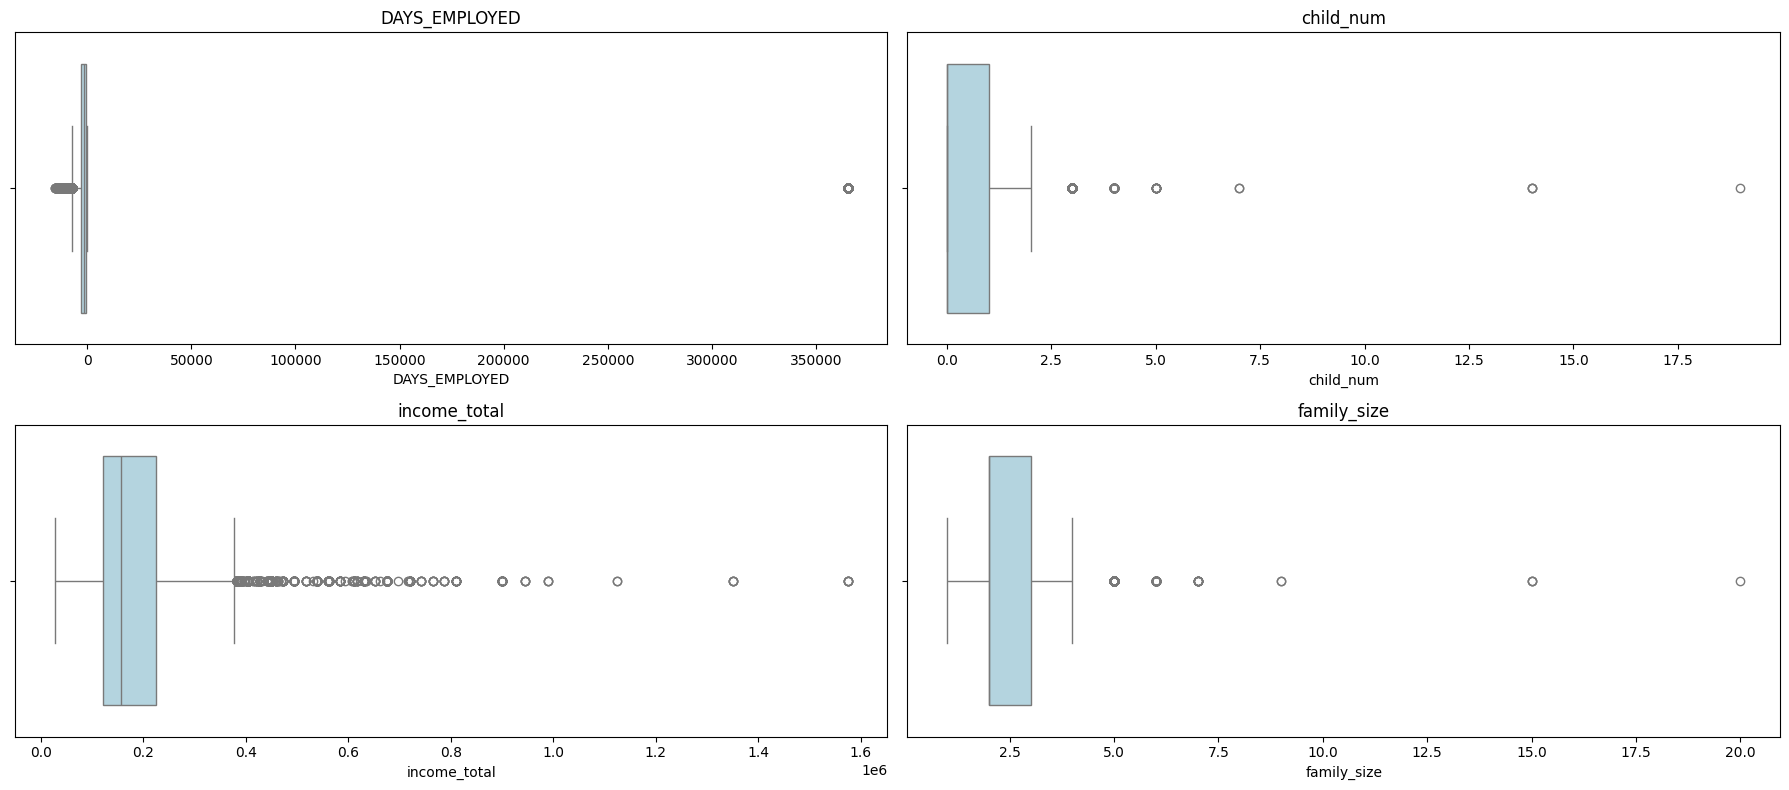

In [ ]:
# IQR기준 이상치 시각화
import matplotlib.pyplot as plt
import math
import seaborn as sns

def detect_outliers_fast(df):
    # Calculate IQR without NaN values
    Q1 = df.quantile(0.25, interpolation='midpoint')
    Q3 = df.quantile(0.75, interpolation='midpoint')
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Vectorized outlier detection with NaN handling
    outlier_flags = df.apply(
        lambda col: ~col.between(lower_bound[col.name], upper_bound[col.name]) & col.notna()
    )
    return outlier_flags


# 시각화 대상
columns_to_visualize = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'child_num', 'income_total', 'family_size']
df_to_visualize = x_numerical[columns_to_visualize]

# 구한 이상치가 0인 경우를 제외하고 표기
x_outliers = detect_outliers_fast(df_to_visualize)
outliers_to_see = x_outliers.sum()[x_outliers.sum()>0]

# 설정: 가로 그래프 개수
cols = 2
num_vars = len(outliers_to_see.index)
rows = math.ceil(num_vars / cols)  # 필요한 행(row) 수 계산

# 서브플롯 생성
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))  # 전체 figure 크기 조정
axes = axes.flatten()  # 2D 배열을 1D로 변환하여 인덱싱 편리하게

# 그래프 그리기
for var_idx, var_nm in enumerate(outliers_to_see.index):
    ax = axes[var_idx]
    sns.boxplot(x=df_to_visualize[var_nm], ax=ax, color='lightblue')
    ax.set_title(f'{var_nm}')
    ax.set_xlabel(var_nm)

# 빈 서브플롯 숨기기
for i in range(num_vars, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 수치형 변수의 전처리 진행 : 최소값 조정 및 로그변환

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 최소값 조정
x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']] = x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']] + x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']].min()*-1

# 로그변환
x_numerical[['child_num', 'income_total', 'DAYS_EMPLOYED']] = x_numerical[['child_num', 'income_total', 'DAYS_EMPLOYED']].apply(lambda x : np.log1p(x))

# Min-Max Scaler 적용
min_max_scaler = MinMaxScaler()
x_numerical[['DAYS_BIRTH']]  = min_max_scaler.fit_transform(x_numerical[['DAYS_BIRTH']])

In [ ]:
x_numerical.head(3)

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,0.000000,12.218500,0.644982,9.306105,1,0,0,0,2.0,54.0
1,0.693147,12.419170,0.789362,9.559165,1,0,0,1,3.0,55.0
2,0.000000,13.017005,0.347624,9.330787,1,0,1,0,2.0,38.0


### 범주형 변수의 EDA 및 전처리 방향

* 전체 변수 : `gender`, `car`, `reality`, `income_type`, `family_type`, `house_type`, `occyp_type`, `edu_type`
* 모델의 혼동(상위관계 여부)을 방지하고자 `OneHotEncoder` :  `gender`, `car`, `reality`, `income_type`, `family_type`, `house_type`
  * 대다수의 변수가 2~6개의 unique값을 가져 크게 어려움은 없을 것으로 보임

* 순서가 중요한 Ordinal변수에 대해서 `OrdinalEncoder`로 우선순위를 지정 : `edu_type`
* unique값이 18개로 많은 편이며, 모델의 상하관계 혼동도 방지하고자 `LeaveOneOutEncoder`(타겟 인코딩) : `occyp_type`

In [ ]:
# 범주형 변수 추출
x_categorical = X_train.select_dtypes(include=['object'])

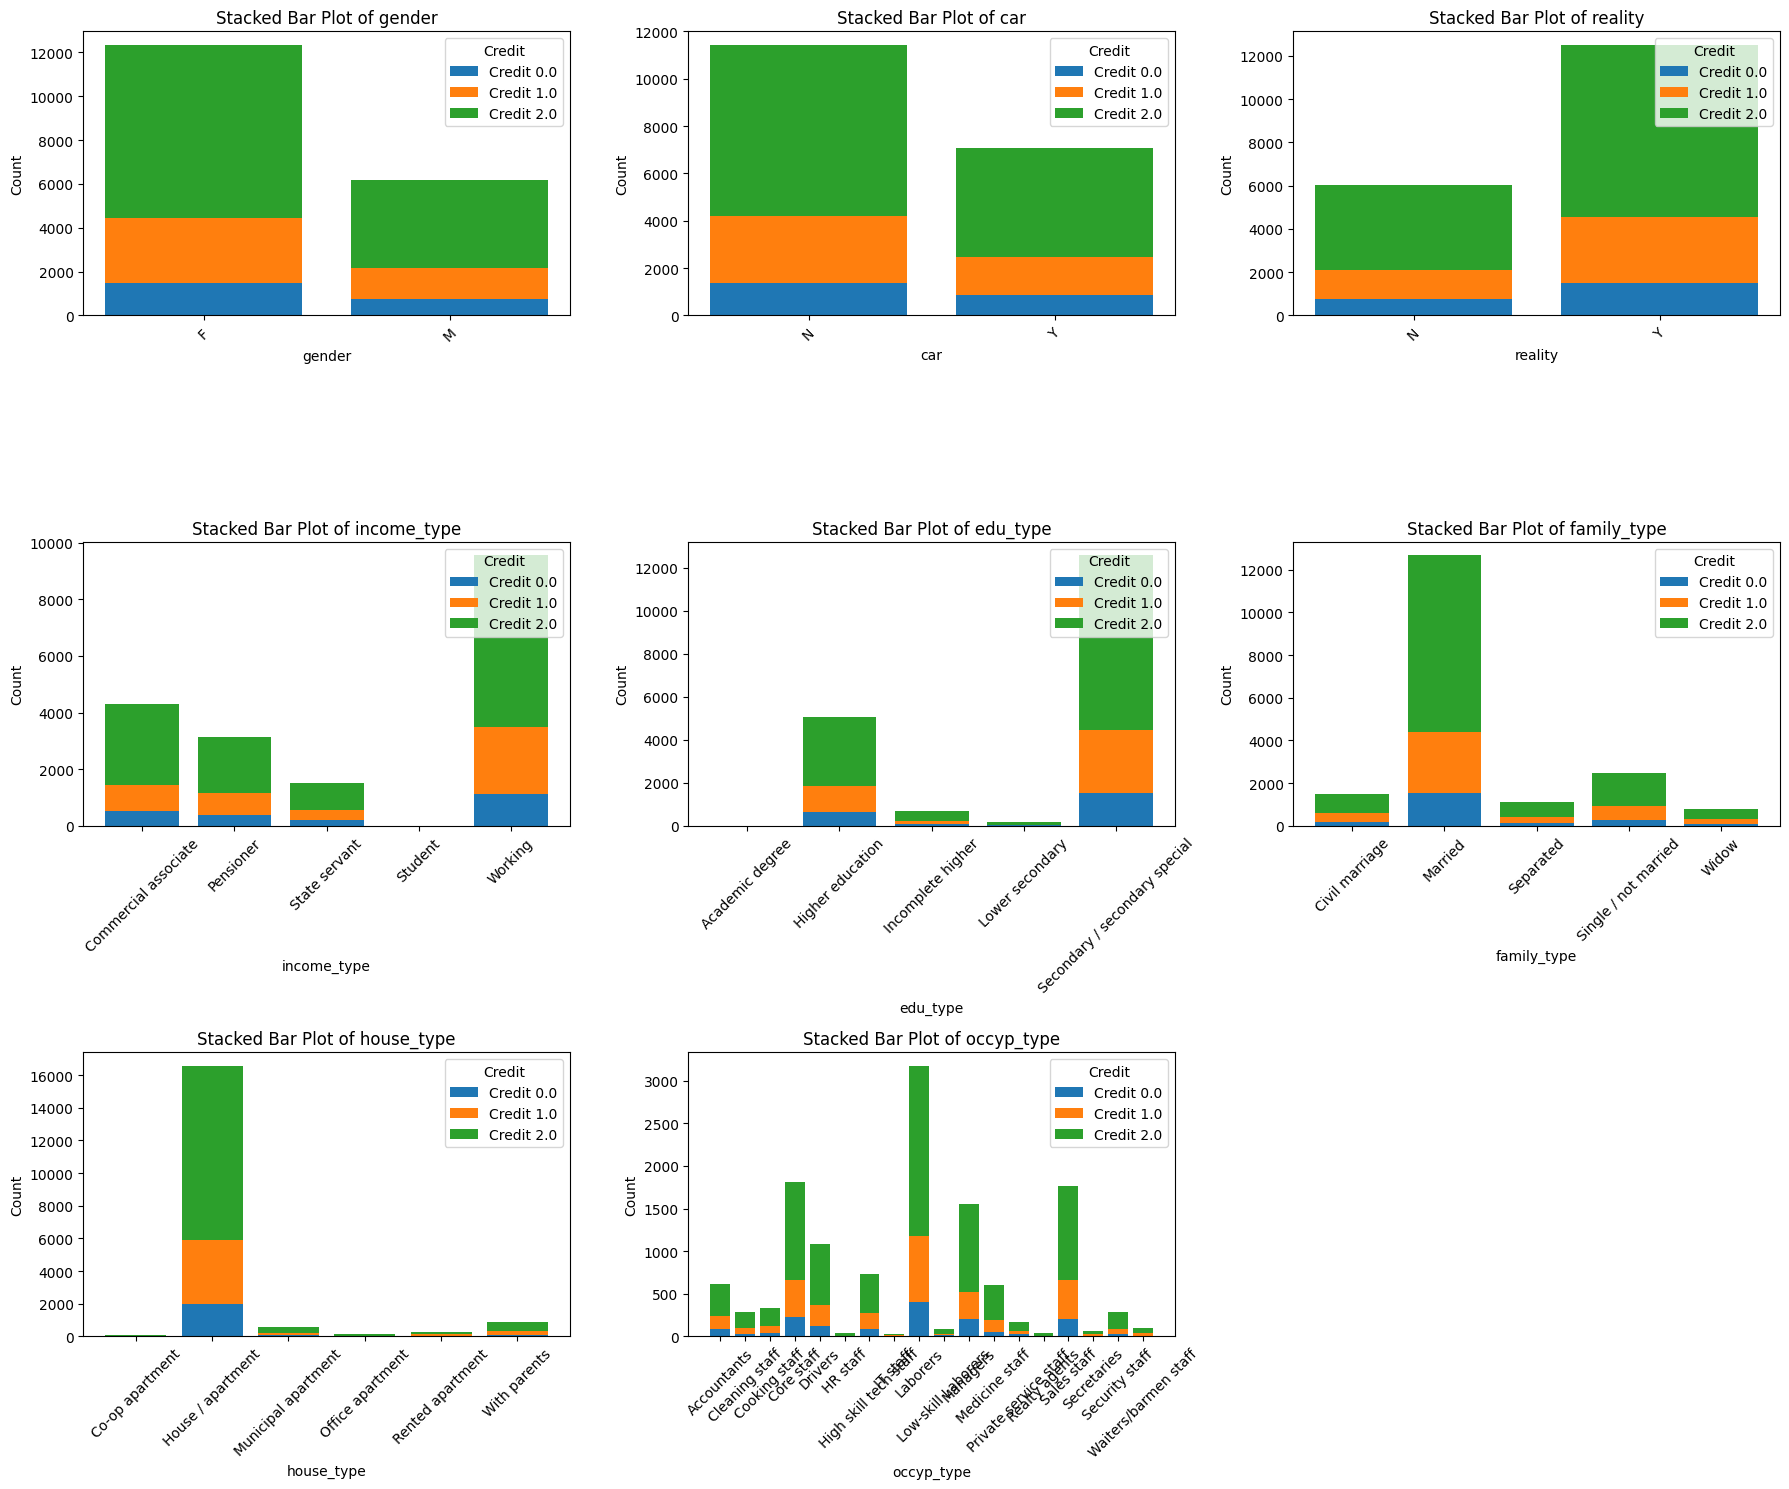

In [ ]:
# 전반적인 시각화

import math
import matplotlib.pyplot as plt
import numpy as np

# credit 데이터 합치기
combined_data = x_categorical.copy()
combined_data['credit'] = y_train.copy()  # 동일한 인덱스를 기준으로 credit 추가

# 범주형 변수 설정
categorical_columns = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']
cols = 3
num_vars = len(categorical_columns)
rows = math.ceil(num_vars / cols)  # 필요한 행(row) 수 계산

# 서브플롯 생성
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))  # 전체 figure 크기 조정
axes = axes.flatten()  # 2D 배열을 1D로 변환하여 인덱싱 편리하게

# 그래프 그리기
for idx, var_nm in enumerate(categorical_columns):
    ax = axes[idx]

    # 데이터 그룹화 및 스택 데이터 계산
    stacked_data = combined_data.groupby([var_nm, 'credit']).size().unstack(fill_value=0)

    # 각 카테고리의 막대 그래프 그리기
    bottom_values = np.zeros(len(stacked_data))
    for credit_value in stacked_data.columns:
        ax.bar(stacked_data.index, stacked_data[credit_value], bottom=bottom_values, label=f'Credit {credit_value}')
        bottom_values += stacked_data[credit_value]

    # 그래프 설정
    ax.set_title(f'Stacked Bar Plot of {var_nm}')
    ax.set_xlabel(var_nm)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Credit', loc='upper right')

# 빈 서브플롯 숨기기
for i in range(num_vars, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 범주형 변수의 전처리 진행 : OrdinalEncoder (edu_type)

In [ ]:
# Label인코딩 후 (Order값은 낮은 것부터 입력)

from sklearn.preprocessing import OrdinalEncoder

order = [
    'Lower secondary',
    'Secondary / secondary special',
    'Incomplete higher',
    'Higher education',
    'Academic degree'
]

o_encoder = OrdinalEncoder(categories=[order])
oe_df = o_encoder.fit_transform(x_categorical[['edu_type']])
x_categorical['edu_type'] = oe_df.flatten()

### 범주형 변수의 전처리 진행 : OneHotEncoder (gender, car, reality, income_type, family_type, house_type)

In [ ]:
# One-hot 인코딩 데이터프레임 생성

from sklearn.preprocessing import OneHotEncoder

one_hot_columns = ['gender', 'car', 'reality', 'income_type', 'family_type', 'house_type']

oh_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = oh_encoder.fit_transform(x_categorical[one_hot_columns])
encoded_col_names = oh_encoder.get_feature_names_out(input_features=one_hot_columns)

df_onehot_encoded = pd.DataFrame(onehot_encoded, columns=encoded_col_names, index=x_categorical.index)

# Ont-hot인코딩된 데이터프레임으로 교체
x_categorical.drop(one_hot_columns, axis=1, inplace=True)
x_categorical = pd.concat([x_categorical, df_onehot_encoded], axis=1)

### 범주형 변수의 전처리 진행 : LeaveOneOutEncoder (occyp_type)

In [ ]:
import category_encoders as ce
import joblib

x_column = 'occyp_type'

leave_one_out_encoder = ce.LeaveOneOutEncoder(cols=x_column, sigma=0.1, return_df=True)
df_target_encoded = leave_one_out_encoder.fit_transform(x_categorical[x_column], Y_train)

joblib.dump(leave_one_out_encoder, 'encoder_leave_one_out.pkl')

x_categorical['occyp_type'] = df_target_encoded['occyp_type']

## 전처리 기능 함수화 및 저장

In [ ]:
import pandas as pd
import numpy as np
import os
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
import category_encoders as ce
import joblib
from pkb_sqlite3 import DB_sqlite3

def preprocess_x_data(train_or_test:str, dataset:list[DataFrame], output_name:dict)->None:

    # 파라메터 검증 및 데이터셋 복사
    if train_or_test == 'train':
        if len(dataset) == 2:
            X_train = dataset[0].copy()
            Y_train = dataset[1].copy()
        else:
            return 'train인 경우 x,y 데이터가 필요합니다'
    elif train_or_test == 'test':
        if len(dataset) == 1:
            X_train = dataset[0].copy()
        else:
            return 'test인 경우 x 데이터만 필요합니다'
    else:
        return 'train 또는 test만 입력 가능합니다'

    
    # (공통)결측치 대체 : occyp_type
    def fill_occyp_type(row):
        if pd.isna(row['occyp_type']):
            if row['DAYS_EMPLOYED'] > 0:
                return 'NoJob'
        return row['occyp_type']

    X_train['occyp_type'] = X_train.apply(fill_occyp_type, axis=1)

    # 수치형 변수 작업
    x_numerical = X_train.select_dtypes(include=['float64', 'int64'])

    ## 최소값 조정
    x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']] = x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']] + x_numerical[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']].min()*-1

    ## 로그변환
    x_numerical[['child_num', 'income_total', 'DAYS_EMPLOYED']] = x_numerical[['child_num', 'income_total', 'DAYS_EMPLOYED']].apply(lambda x : np.log1p(x))

    ## Min-Max Scaler 적용
    min_max_scaler = MinMaxScaler()
    x_numerical[['DAYS_BIRTH']]  = min_max_scaler.fit_transform(x_numerical[['DAYS_BIRTH']])


    # 범주형 변수 작업
    x_categorical = X_train.select_dtypes(include=['object'])

    ## Label인코딩
    order = [
        'Lower secondary',
        'Secondary / secondary special',
        'Incomplete higher',
        'Higher education',
        'Academic degree'
    ]

    o_encoder = OrdinalEncoder(categories=[order])
    oe_df = o_encoder.fit_transform(x_categorical[['edu_type']])
    x_categorical['edu_type'] = oe_df.flatten()

    ## One-hot 인코딩
    one_hot_columns = ['gender', 'car', 'reality', 'income_type', 'family_type', 'house_type']

    oh_encoder = OneHotEncoder(sparse_output=False)
    onehot_encoded = oh_encoder.fit_transform(x_categorical[one_hot_columns])
    encoded_col_names = oh_encoder.get_feature_names_out(input_features=one_hot_columns)

    df_onehot_encoded = pd.DataFrame(onehot_encoded, columns=encoded_col_names, index=x_categorical.index)

    x_categorical.drop(one_hot_columns, axis=1, inplace=True)
    x_categorical = pd.concat([x_categorical, df_onehot_encoded], axis=1)


    ## LeaveOneOut인코딩
    x_column = 'occyp_type'

    ### 파일로 저장해둔 인코더가 있으면 로딩, 아니면 생성
    if os.path.isfile('encoder_leave_one_out.pkl'):
        leave_one_out_encoder = joblib.load('encoder_leave_one_out.pkl')
    else:
        leave_one_out_encoder = ce.LeaveOneOutEncoder(cols=x_column, sigma=0.1, return_df=True)

    ### 인코딩된 데이터 생성 및 인코더 업데이트
    if train_or_test == 'train':
        df_target_encoded = leave_one_out_encoder.fit_transform(x_categorical[x_column], Y_train)
    elif train_or_test == 'test':
        df_target_encoded = leave_one_out_encoder.transform(x_categorical[x_column])
    joblib.dump(leave_one_out_encoder, 'encoder_leave_one_out.pkl')

    x_categorical['occyp_type'] = df_target_encoded['occyp_type']


    # 나누어 작업한 수치형/범주형 변수 합치고 저장
    x_train_preprocessed = pd.concat([x_categorical, x_numerical], axis=1)
    if train_or_test == 'train':
        x_train_preprocessed = pd.concat([x_train_preprocessed, Y_train], axis=1)
    elif train_or_test == 'test':
        pass

    ## CSV저장 
    x_train_preprocessed.to_csv(output_name['csv_file_name']) # 'train_preprocessed.csv'

    ## DB저장 (아래 함수는 이미 테이블이 있는 경우 덮어씀)
    db_controller.df_to_table(output_name['db_table_name'], x_train_preprocessed) # 'train_pre'

    return '작업이 완료되었습니다'

In [ ]:
# train 데이터 전처리
preprocess_x_data(train_or_test='train', 
                  dataset=[X_train, Y_train], 
                  output_name={'csv_file_name':'train_preprocessed.csv', 
                               'db_table_name':'train_pre'}
                  )

'작업이 완료되었습니다'

In [ ]:
# 전처리 후 db저장된 결과 확인
db_controller.search_db_show_df("SELECT * FROM train_pre").head(3)

,edu_type,occyp_type,gender_F,gender_M,car_N,car_Y,reality_N,reality_Y,income_type_Commercial associate,income_type_Pensioner,...,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,3.0,1.461445,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,12.218500,0.644982,9.306105,1,0,0,0,2.0,54.0,1.0
1,1.0,1.488029,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,12.419170,0.789362,9.559165,1,0,0,1,3.0,55.0,1.0
2,3.0,1.652069,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,13.017005,0.347624,9.330787,1,0,1,0,2.0,38.0,2.0


In [ ]:
# test 데이터 전처리
preprocess_x_data(train_or_test='test', 
                  dataset=[X_test], 
                  output_name={'csv_file_name':'test_preprocessed.csv', 
                               'db_table_name':'test_pre'}
                  )

'작업이 완료되었습니다'

## 전처리한 데이터 및 autogluon활용한 모델 고도화 

In [ ]:
from sklearn.model_selection import train_test_split

pre_df_train = db_controller.search_db_show_df("SELECT * FROM train_pre")

# 데이터 나누기
Y_train = pre_df_train['credit'].copy()
pre_X_train = pre_df_train.drop('credit',axis=1).copy()
X_test = df_test.copy()


# 데이터 분할
pre_x_train, pre_x_validate, y_train, y_validate= train_test_split(pre_X_train, Y_train, test_size=0.3, random_state=42, stratify=Y_train)

In [ ]:
from autogluon.tabular import TabularPredictor
import numpy as np

# 저장할 경로 지정
path = 'autogluon_2secondmodel' # 저장할 경로

# AutoGluon을 위해 데이터프레임으로 병합
train_data = pre_x_train
train_data['target'] = y_train

val_data = pre_x_validate
val_data['target'] = y_validate

# AutoGluon 학습
predictor = TabularPredictor(
    label='target', 
    problem_type='multiclass', 
    eval_metric='log_loss', 
    verbosity=2,
    path=path,
)
predictor.fit(
    train_data,
    tuning_data=val_data,
    time_limit=3600,  # 시간 제한 설정 (1시간)
    num_gpus=1,
    presets='best_quality',
    use_bag_holdout=True
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
Memory Avail:       5.04 GB / 15.94 GB (31.6%)
Disk Space Avail:   504.61 GB / 931.51 GB (54.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "e:\0_Backup\14.Python\metacode_202412_study_creditmodeling\autogluon_2secondmodel"
Train Data Rows:    18519
Train Data Columns: 34
Tuning Data Rows:    7938
Tuning Data Columns: 34
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to p

* 리더보드

In [ ]:
predictor.leaderboard(pre_x_validate, extra_metrics=['balanced_accuracy', 'f1_weighted', 'roc_auc_ovr_weighted'])

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.721621,-0.721621,log_loss,66.038581,35.591943,2484.289781,0.013003,0.001998,1.126650,3,True,48
1,LightGBM_r96_BAG_L2,-0.723399,-0.723399,log_loss,60.437314,32.402319,2207.033812,1.693396,1.249881,17.496655,2,True,46
2,LightGBMXT_BAG_L2,-0.723595,-0.723595,log_loss,59.718009,31.786725,2204.540157,0.974091,0.634287,15.003000,2,True,31
3,XGBoost_BAG_L2,-0.723949,-0.723949,log_loss,59.537626,31.807227,2229.341661,0.793707,0.654789,39.804505,2,True,38
4,CatBoost_r177_BAG_L2,-0.724051,-0.724051,log_loss,59.057112,31.241331,2274.504236,0.313194,0.088893,84.967080,2,True,41
5,LightGBM_BAG_L2,-0.724066,-0.724066,log_loss,59.263655,31.515064,2208.849041,0.519737,0.362626,19.311885,2,True,32
6,NeuralNetTorch_r79_BAG_L2,-0.724087,-0.724087,log_loss,60.398604,32.529583,2349.523849,1.654686,1.377145,159.986692,2,True,42
7,CatBoost_BAG_L2,-0.724257,-0.724257,log_loss,59.122199,31.250390,2292.868759,0.378280,0.097952,103.331603,2,True,35
8,LightGBM_r131_BAG_L2,-0.724293,-0.724293,log_loss,60.727484,32.341873,2232.318439,1.983566,1.189435,42.781282,2,True,43
9,CatBoost_r9_BAG_L2,-0.724313,-0.724313,log_loss,59.698261,31.379199,2428.618669,0.954343,0.226760,239.081513,2,True,45


## 제출용 CSV파일 생성 및 제출하기

* 제출결과
  * Public점수 : 0.7384256792
  * Private점수 : 0.7185042016

In [ ]:
# 필요한 데이터 불러오기
pre_df_test = db_controller.search_db_show_df("SELECT * FROM test_pre")
df_sample_submission = db_controller.search_db_show_df('SELECT * FROM sample_submission')

# 예측 및 제출 데이터 생성
y_pred = predictor.predict_proba(pre_df_test)
df_sample_submission.iloc[:,1:]=y_pred

In [ ]:
# 저장 및 값 확인
df_sample_submission.to_csv('submission_pkb.csv', index=False)
df_sample_submission.head(5)

,index,0,1,2
0,26457,0.047518,0.103970,0.848513
1,26458,0.126270,0.316703,0.557027
2,26459,0.084927,0.117985,0.797088
3,26460,0.091055,0.101548,0.807397
4,26461,0.083222,0.160538,0.756240


# 향후 추가해보기

* cuml을 활용한 SHAP Kernel Explainer 활용
  * cuml 설치(Docker활용)
    * https://docs.rapids.ai/install/#selector
        ```shell
        docker run --gpus all --pull always --rm -it \
        --shm-size=1g --ulimit memlock=-1 --ulimit stack=67108864 \
        nvcr.io/nvidia/rapidsai/base:24.12-cuda12.0-py3.12

* 파생변수 생성